In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import v2
from model.BaseCNN import BaseCNN
import matplotlib.pyplot as plt
import random

In [87]:
INPUT_SIZE = 1
OUTPUT_SIZE = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 1000
NUM_EPOCHS = 1

In [88]:
transform = v2.Compose([
        v2.ToImage(), 
        # Rotate between -10 and 10 
        # Scale between 0.8 and 1.2
        # Translate between 0.08 and 0.08
        # Shear between -0.3 and 0.3
        # Normalize the dataset
        v2.RandomAffine(degrees=(-10, 10), scale=(0.8, 1.2), translate=(0.08, 0.08), shear=(-0.3, 0.3)),
        v2.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5,), (0.5,))
    ])

# Load MNIST dataset
train_dataset = datasets.MNIST(
        root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# Load MNIST dataset
val_dataset = datasets.MNIST(
        root='./data', train=False, download=True, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

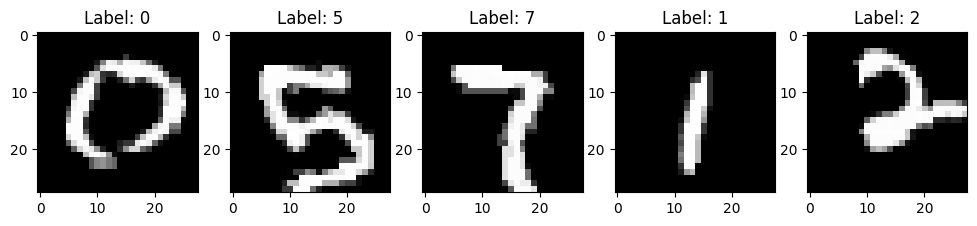

In [89]:
plt.figure(figsize=(12, 6))
for i in range(5):
    image, label = train_dataset[random.randint(0, len(train_dataset) - 1)]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
plt.show()

In [ ]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BaseCNN(INPUT_SIZE, OUTPUT_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        print(outputs)
        print("labels:" + labels)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

    average_loss = total_loss / len(train_dataloader)
    train_losses.append(average_loss)
    print(f'Train Epoch: {epoch}, Average Loss: {average_loss}')

    model.eval()
    val_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += loss_function(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_dataloader.dataset)
    val_losses.append(val_loss)
    accuracy = correct / len(val_dataloader.dataset)
    print(f'Validation Epoch: {epoch}, Average Loss: {val_loss}, Accuracy: {accuracy * 100}%')


In [ ]:
# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()